<a href="https://colab.research.google.com/github/dgymjol/cs231n/blob/main/YAI_3rd_week_%EB%B0%95%EC%84%9C%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Consider the Convolutional Neural Network and answer the following questions.**

Input shape: 32x32x3 
10 5x5 filters, stride 1, pad 2

(1) What is the output volume size? **32X32X10**

(2) What is the number of parameters in this layer? (Each filter has one bias) **760**


**2. Complete CNN in YAI_3rd_week.ipynb**

    Problem: Classification

    Dataset: FashionMNIST

    Model: LeNet-5(http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)


- You don’t have to do feature map selection at Layer 3.

- In case of LeNet-5, the input size is [32x32x1]. So you need to use padding.
- You can choose freely any pooling, padding, activation function, loss function and optimizer.
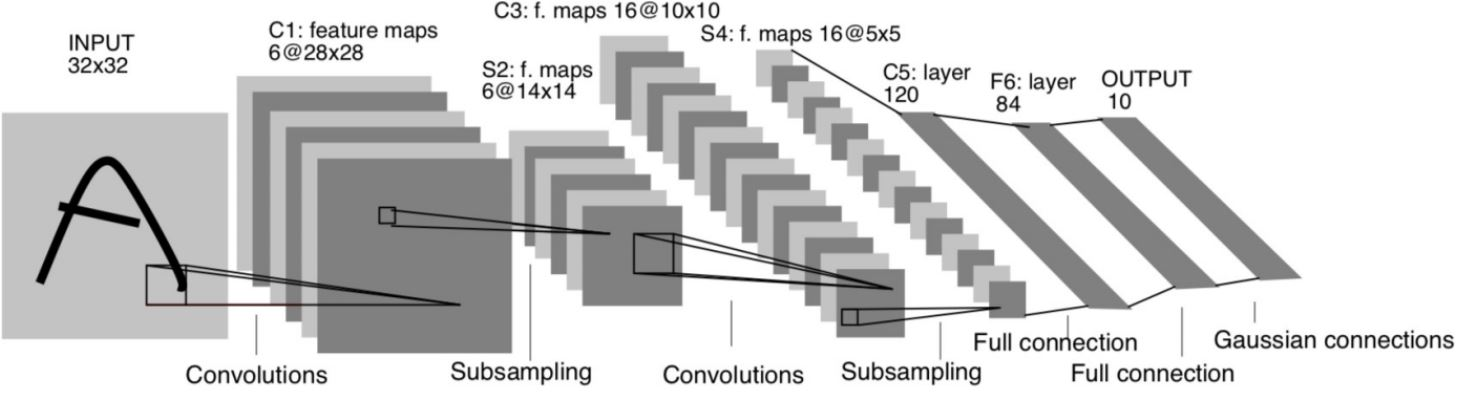

# LeNet-5 FashionMNIST Classification
Implement
*   Set hyper parameters
*   Call dataset from torchvision & make dataloader
*   Build a LeNet-5
*   Instantiate LeNet & define loss function and optimizer
*   Training
*   Test







In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Set seed
torch.manual_seed(777)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set hyper parameters 


In [17]:
num_epochs = 10
batch_size = 64
learning_rate = 0.01

# Call dataset from torchvision & make dataloader

In [18]:
# Load dataset 
train_dataset = torchvision.datasets.FashionMNIST(
    root="data", # root : 학습/테스트 데이터가 저장되는 경로
    train=True,  # train : 학습용인지 테스트용인지 지정
    download = True,  # root에 데이터가 없다면 인터넷에서 다운로드할 것인지 지정
    transform = transforms.ToTensor()  # # 텐서 데이터로 변환 : PIL Image나 NumPy ndarray 를 FloatTensor 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = "data",
    train=False,
    download = True,
    transform=transforms.ToTensor()
)


# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,drop_last=True)

# Build a LeNet-5

In [19]:
# LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Convolution layer1 || 1*28*28 -> filter 크기=5(or output depth), Stride=1, Zero Padding = 2 -> 6*28*28
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2, stride=1) # 1st:input depth=1 , 2nd:filter 개수=6, 3rd:filter크기=5
        # Convolution layer2 || 6*14*14 -> filter 크기=5, Stride=1 -> 16*10*10
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1) # 1st:input depth=6 , 2nd:filter 개수=16, 3rd:filter크기=5
        
        # Fully-Connected layer1 || weight와 bias 사용해서 linear transformation || 16*5*5 -> 120 
        self.fc1 = nn.Linear(16*5*5, 120) # in_featrues = 16*5*5, out_features = 120
        # Fully-Connected layer2 || 120 -> 84
        self.fc2 = nn.Linear(120, 84) # in_featrues = 120, out_features = 84
        # Fully-Connected layer2 || 84 -> 10
        self.fc3 = nn.Linear(84, 10) # in_featrues = 84, out_features = 10

            
    # input->conv1->activation->maxpooling->conv2->activation->maxpooling->flatten->linear->activation->linear->activation->linear(->loss)
    def forward(self, x):

        # Subsampling layer1 || 28*28 -> filter 크기=2, Stride=2 -> 14*14
        x = nn.functional.max_pool2d(nn.functional.relu(self.conv1(x)),(2, 2)) # conv1->activation(relu)->maxpooling
        # Subsampling layer2 || 10*10 -> filter 크기=2, Stride=2 -> 5*5
        x = nn.functional.max_pool2d(nn.functional.relu(self.conv2(x)),(2, 2)) # conv2->activation(relu)->maxpooling

        #full connection
        x = torch.flatten(x, 1) # 2D 이미지를 연속된 배열로 변환 (dim=0의 미니배치 차원은 유지됨) # flatten
        x = nn.functional.relu(self.fc1(x)) # linear -> activation
        x = nn.functional.relu(self.fc2(x)) # linear -> activation

        #output
        x = self.fc3(x) # linear

        return x

# Instantiate LeNet & define loss function and optimizer


In [25]:
# model
model = LeNet().to(device)
print(model)

# Loss function & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Training

In [26]:
total_batch = len(train_loader)

for e in range(num_epochs):
    avg_loss = 0
    for X, Y in train_loader:
        # train dataset에서 학습시킨 data 가져오기
        X = X.to(device)
        Y = Y.to(device)

        # 예측하고 loss계산하고 최적화하기
        y_pred = model(X)
        loss = criterion(y_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # epoch마다 average loss 출력하기
        avg_loss += loss / total_batch

    print(f'[Epoch: {e+1}] - Average loss: {avg_loss:.4f}')

[Epoch: 1] - Average loss: 0.4873
[Epoch: 2] - Average loss: 0.3559
[Epoch: 3] - Average loss: 0.3307
[Epoch: 4] - Average loss: 0.3114
[Epoch: 5] - Average loss: 0.3135
[Epoch: 6] - Average loss: 0.3040
[Epoch: 7] - Average loss: 0.2918
[Epoch: 8] - Average loss: 0.2908
[Epoch: 9] - Average loss: 0.3008
[Epoch: 10] - Average loss: 0.2804


# Test

In [27]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels=labels.to(device)

        # 학습시킨 model에 test image를 통과시켜 출력 계산
        outputs = model(images)
        # 가장 높은 값을 가지는 class를 정답으로 선택
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {(100 * correct / total):.4f}%%')

Accuracy of the network on the 10000 test images: 88.4100%%
